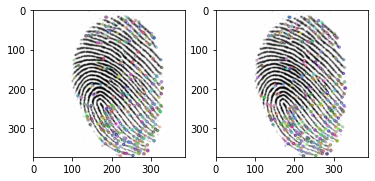

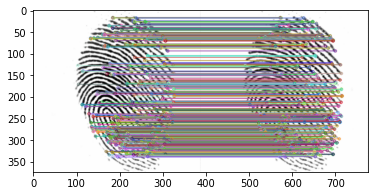

Fingerprint matches.


In [4]:
import cv2
import os
import sys
import numpy
import matplotlib.pyplot as plt
#from enhance import image_enhance
from skimage.morphology import skeletonize, thin

os.chdir("/Users/YASH/OneDrive - vit.ac.in/Desktop/BIOMETRICS-PROJECT/")

def removedot(invertThin):
    temp0 = numpy.array(invertThin[:])
    temp0 = numpy.array(temp0)
    temp1 = temp0/255
    temp2 = numpy.array(temp1)
    temp3 = numpy.array(temp2)
    
    enhanced_img = numpy.array(temp0)
    filter0 = numpy.zeros((10,10))
    W,H = temp0.shape[:2]
    filtersize = 6
    
    for i in range(W - filtersize):
        for j in range(H - filtersize):
            filter0 = temp1[i:i + filtersize,j:j + filtersize]

            flag = 0
            if sum(filter0[:,0]) == 0:
                flag +=1
            if sum(filter0[:,filtersize - 1]) == 0:
                flag +=1
            if sum(filter0[0,:]) == 0:
                flag +=1
            if sum(filter0[filtersize - 1,:]) == 0:
                flag +=1
            if flag > 3:
                temp2[i:i + filtersize, j:j + filtersize] = numpy.zeros((filtersize, filtersize))

    return temp2


def get_descriptors(img):
	clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
	img = clahe.apply(img)
	#img = image_enhance.image_enhance(img)
	img = numpy.array(img, dtype=numpy.uint8)
	# Threshold
	ret, img = cv2.threshold(img, 127, 255, cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)
	# Normalize to 0 and 1 range
	img[img == 255] = 1
	
	#Thinning
	skeleton = skeletonize(img)
	skeleton = numpy.array(skeleton, dtype=numpy.uint8)
	skeleton = removedot(skeleton)
	# Harris corners
	harris_corners = cv2.cornerHarris(img, 3, 3, 0.04)
	harris_normalized = cv2.normalize(harris_corners, 0, 255, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32FC1)
	threshold_harris = 125
	# Extract keypoints
	keypoints = []
	for x in range(0, harris_normalized.shape[0]):
		for y in range(0, harris_normalized.shape[1]):
			if harris_normalized[x][y] > threshold_harris:
				keypoints.append(cv2.KeyPoint(y, x, 1))
	# Define descriptor
	orb = cv2.ORB_create()
	# Compute descriptors
	_, des = orb.compute(img, keypoints)
	return (keypoints, des);


def main():
	image_name = sys.argv[1]
	img1 = cv2.imread("database/101_1.tif", cv2.IMREAD_GRAYSCALE)
	kp1, des1 = get_descriptors(img1)
	
	image_name = sys.argv[2]
	img2 = cv2.imread("database/101_1.tif", cv2.IMREAD_GRAYSCALE)
	kp2, des2 = get_descriptors(img2)
	
	# Matching between descriptors
	bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
	matches = sorted(bf.match(des1, des2), key= lambda match:match.distance)
	# Plot keypoints
	img4 = cv2.drawKeypoints(img1, kp1, outImage=None)
	img5 = cv2.drawKeypoints(img2, kp2, outImage=None)
	f, axarr = plt.subplots(1,2)
	axarr[0].imshow(img4)
	axarr[1].imshow(img5)
	plt.show()
	# Plot matches
	img3 = cv2.drawMatches(img1, kp1, img2, kp2, matches, flags=2, outImg=None)
	plt.imshow(img3)
	plt.show()
	
	# Calculate score
	score = 0;
	for match in matches:
		score += match.distance
	score_threshold = 33
	if score/len(matches) < score_threshold:
		print("Fingerprint matches.")
	else:
		print("Fingerprint does not match.")
	
	
	
if __name__ == "__main__":
	try:
		main()
	except:
		raise